In [1]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

In [4]:
import random

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(np.random.rand(5), torch.randn(5))

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ] tensor([ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845])


# Settings

In [5]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 1
WINDOW = True

# Read Data

In [6]:
from codes.dataset import DicomDataset, DicomsDataset, TmpsDataset
import codes.augmentation as aug

In [7]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval

def statistics(dataloader):
    
    ssim_ = []
    psnr_ = []
    snr_ = []
    mae_ = []
    
    window = 1000 if WINDOW else 4096
    shift = 500 if WINDOW else 1024
    
    xs = np.zeros(window)
    ys = np.zeros(window)
    
    for index, data in tqdm(enumerate(dataloader)):
        x, y = data
        x = x.float()
        y = y.float()
        _ssim = ssim(x, y.float(), data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(x, y.float(), 1.0)
        _snr = SNR()(x, y.float())
        _mae = MAELoss()(x.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        x = x.squeeze().numpy() * window - shift
        y = y.squeeze().numpy() * window - shift

        x_hist = np.histogram(x, bins=window)[0]
        y_hist = np.histogram(y, bins=window)[0]
        xs = np.add(x_hist, xs)
        ys = np.add(y_hist, ys)
        
    xs = xs/len(xs)
    ys = ys/len(ys)
    
    bins = np.arange(len(xs)) - shift
    
    plt.style.use("ggplot")
    fig = plt.figure() 
    ax = plt.subplot(111)

    ax.plot(bins, xs, label="CBCT", alpha=0.5)
    ax.plot(bins, ys, label="CT", alpha=0.5)
    ax.set_yscale("log")
   
    ax.legend(loc="upper center")
    ax.fill_between(bins, 0, xs, alpha=0.3)
    ax.fill_between(bins, 0, ys, alpha=0.3)
    ax.set_xlabel("HU (CT number)")
    ax.set_ylabel("Intensity")
    
    plt.savefig("L2 hu histogram window wo cropping.png")
    print("ssim: {}, \npsnr: {}, \nsnr: {}, \nmae: {}".format(sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_)))

In [8]:
pelvic_train_case_path = 'L2_pelvic_processed/train/*_*'
pelvic_train_id_case_path = 'L2_pelvic_processed/train_id/*_*'
pelvic_test_case_path = 'L2_pelvic_processed/test/*_*'

In [9]:
geometry_aug = None # aug.get_validation_augmentation()

In [10]:
trainset_pelvic = TmpsDataset(pelvic_train_case_path, window=WINDOW, geometry_aug=geometry_aug)
trainset_id_pelvic = TmpsDataset(pelvic_train_id_case_path, window=WINDOW, geometry_aug=geometry_aug)
testset = TmpsDataset(pelvic_test_case_path, window=WINDOW, geometry_aug=geometry_aug)

In [11]:
len(trainset_pelvic), len(trainset_id_pelvic), len(testset)

(1204, 1204, 656)

In [12]:
dataset = ConcatDataset([trainset_pelvic, trainset_id_pelvic, testset])

In [13]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH, shuffle=False, num_workers=8)

3064it [01:00, 50.64it/s]


ssim: 0.8763101126988936, 
psnr: 23.898200715490795, 
snr: 11.84266807037763, 
mae: 0.02278475711753169


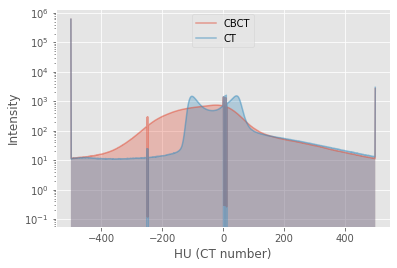

In [14]:
statistics(dataloader)

In [13]:
paths = sorted(glob.glob(pelvic_train_case_path))
for i in range(0, len(paths), 2):
    scans = DicomSegmentDataset(cbct_path=paths[i+1], ct_path=paths[i],
                         geometry_aug=None, intensity_aug=None, 
                         identity=False, electron=ELECTRON, position="pelvic", segment=SEGMENT, g_coord=G_COORD, l_coord=L_COORD)
    patient_id = scans.patientID()
    print(patient_id, len(scans))

E101006583 29
F222836422 26
M100137352 28
M100972600 27
P100328793 29
P100597458 28
P101069293 28
P102318099 27
P120021311 26
P120486429 29
P1222520471 28
P122803142 28
P200944502 28
Q100431090 28
Q101058433 30
Q101171806 27
Q101313162 27
Q1029263962 28
Q102965115 26


In [14]:
paths = sorted(glob.glob(pelvic_train_id_case_path))
for i in range(0, len(paths), 2):
    scans = DicomSegmentDataset(cbct_path=paths[i+1], ct_path=paths[i],
                         geometry_aug=None, intensity_aug=None, 
                         identity=False, electron=ELECTRON, position="pelvic", segment=SEGMENT, g_coord=G_COORD, l_coord=L_COORD)
    patient_id = scans.patientID()
    print(patient_id, len(scans))

L101278922 28
N101086364 27
N120943884 28
P100181905 29
P100369203 27
P101661797 28
P120283553 27
P120900184 30
P121236094 28
P1222520472 15
P200366339 26
P201191667 26
P201773436 27
Q101184116 26
Q1029263961 27
Q120541551 29
Q120864308 28
R220907285 30
S102202099 130


In [15]:
paths = sorted(glob.glob(pelvic_test_case_path))
for i in range(0, len(paths), 2):
    scans = DicomSegmentDataset(cbct_path=paths[i+1], ct_path=paths[i],
                         geometry_aug=None, intensity_aug=None, 
                         identity=False, electron=ELECTRON, position="pelvic", segment=SEGMENT, g_coord=G_COORD, l_coord=L_COORD)
    patient_id = scans.patientID()
    print(patient_id, len(scans))

N100899554 26
N102600215 30
P100897195 26
P121128524 32
P220683493 36
P221051048 28
P221436710 27
Q101306078 29
Q103249763 26
Q201180718 27
R221140186 27


In [ ]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR

In [15]:
def hu_histogram(dataloader, ys, xs):
    
    ssim = []
    psnr = []
    snr = []
    mae = []
    
    for index, data in tqdm(enumerate(dataloader)):
        x, y, *_ = data

        _ssim = ssim(x, y.float(), data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(x, y.float(), 1.0)
        _snr = SNR()(x, y.float())
        _mae = MAELoss()(x.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        x = x.squeeze() * 1000 - 500
        y = y.squeeze() * 1000 - 500
        mae += [mean_absolute_error(y, x)]
        x_hist = np.histogram(x, bins=1000)[0]
        y_hist = np.histogram(y, bins=1000)[0]
        xs = np.add(x_hist, xs)
        ys = np.add(y_hist, ys)
        
    xs = xs/len(xs)
    ys = ys/len(ys)
    
    bins = np.arange(len(xs)) - 500
    
    plt.style.use("ggplot")
    fig = plt.figure() 
    ax = plt.subplot(111)

    ax.plot(bins, xs, label="CBCT", alpha=0.7)
    ax.plot(bins, ys, label="CT", alpha=0.7)
    ax.set_yscale("log")
   
    ax.legend(loc="upper center")
    ax.fill_between(bins, 0, xs, alpha=0.5)
    ax.fill_between(bins, 0, ys, alpha=0.5)
    ax.set_xlabel("HU (CT number)")
    ax.set_ylabel("Intensity")
    fig.suptitle("HU histogram of  C_dataset")
    
    plt.savefig("C hu histogram.png")
    print("ssim: {}, \npsnr: {}, \nsnr: {}, \nmae: {}".format(sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_)))

1535it [00:21, 72.20it/s]


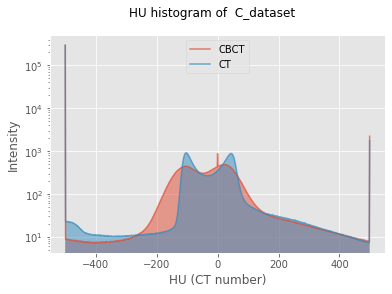

In [16]:
hu_histogram(dataset, np.zeros(1000), np.zeros(1000))